In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE

In [4]:
# Load the dataset
df = pd.read_csv("Datasets/esd.csv")

# Display the first few rows of the dataset
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [5]:
# Separate features and target variable
X = df.drop(columns=['class'])
y = df['class']

# Encode categorical features
# Gender
X['Gender'] = X['Gender'].map({'Male': 1, 'Female': 0})

# Other binary categorical features (Yes/No)
binary_features = ['Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 'Polyphagia', 'Genital thrush', 
                   'visual blurring', 'Itching', 'Irritability', 'delayed healing', 'partial paresis', 
                   'muscle stiffness', 'Alopecia', 'Obesity']
for feature in binary_features:
    X[feature] = X[feature].map({'Yes': 1, 'No': 0})

# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Positive -> 1, Negative -> 0

# Normalize numerical features
scaler = MinMaxScaler()
X['Age'] = scaler.fit_transform(X[['Age']])
X = X.values

In [6]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
X_smote, y_smote = X, y

In [7]:
# Split data into training and testing sets (avoid scaling entire data)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=32)

In [8]:
# Reshape for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_lstm = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [9]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Bidirectional, Dense, Dropout, BatchNormalization, Concatenate, Flatten

# Assuming your input data is in the format (samples, features)
# Define the inputs
inputs = Input(shape=(X_lstm.shape[1], 1))

# Dense layers
x = Dense(128, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Recurrent layers
x_lstm = Bidirectional(LSTM(64, return_sequences=True))(x)
x_gru = Bidirectional(GRU(64, return_sequences=True))(x)

# Concatenate LSTM and GRU outputs
x = Concatenate()([x_lstm, x_gru])
x = Flatten()(x)

# Dense layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=100)
# Train the model
history = model.fit(X_lstm, y, epochs=2000, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_lstm, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.7567 - loss: 0.5302 - val_accuracy: 0.0547 - val_loss: 0.8136
Epoch 2/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8908 - loss: 0.3087 - val_accuracy: 0.0391 - val_loss: 1.0507
Epoch 3/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9428 - loss: 0.1850 - val_accuracy: 0.0391 - val_loss: 1.2156
Epoch 4/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9223 - loss: 0.2127 - val_accuracy: 0.0391 - val_loss: 1.4441
Epoch 5/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9511 - loss: 0.1559 - val_accuracy: 0.0391 - val_loss: 1.6067
Epoch 6/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9631 - loss: 0.1108 - val_accuracy: 0.0391 - val_loss: 1.6502
Epoch 7/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9585 - loss: 0.1087 - val_accuracy: 0.0391 - val_loss: 1.8391
Epoch 8/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9585 - loss: 0.1292 - val_ac

In [11]:
# Save the entire model to a file
model.save('Results/esd/bilstm_model.keras')
# Save only the model's weights to a file
model.save_weights('Results/esd/bilstm_model.weights.h5')
# Save only the model's architecture to a JSON file
model_json = model.to_json()
with open('Results/esd/bistlm_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Save X_test as a NumPy array
np.save('Results/esd/bilstm_X_test.npy', X_test_lstm)

# Save y_test as a NumPy array
np.save('Results/esd/bilstm_y_test.npy', y_test)

# Get the training and validation accuracy and loss values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Save the accuracy and loss values as NumPy arrays
np.save('Results/esd/bilstm_train_acc.npy', train_acc)
np.save('Results/esd/bilstm_val_acc.npy', val_acc)
np.save('Results/esd/bilstm_train_loss.npy', train_loss)
np.save('Results/esd/bilstm_val_loss.npy', val_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


<Figure size 500x300 with 0 Axes>

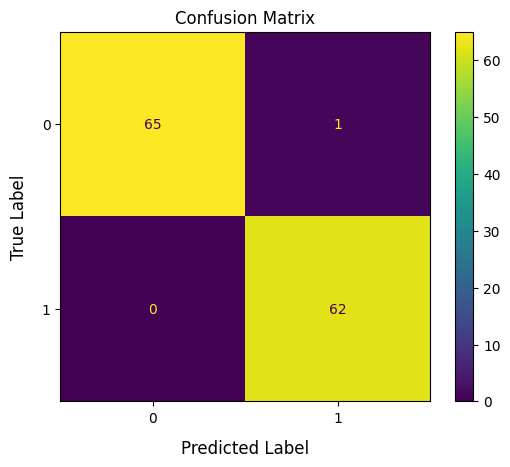

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test) > 0.5
y_pred = y_pred.astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix', fontsize=12, fontweight='normal')
plt.xlabel('Predicted Label', fontsize=12, labelpad=10)
plt.ylabel('True Label', fontsize=12, labelpad=10)
plt.show()
# Set the title and labels

In [13]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        66
           1       0.98      1.00      0.99        62

    accuracy                           0.99       128
   macro avg       0.99      0.99      0.99       128
weighted avg       0.99      0.99      0.99       128



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


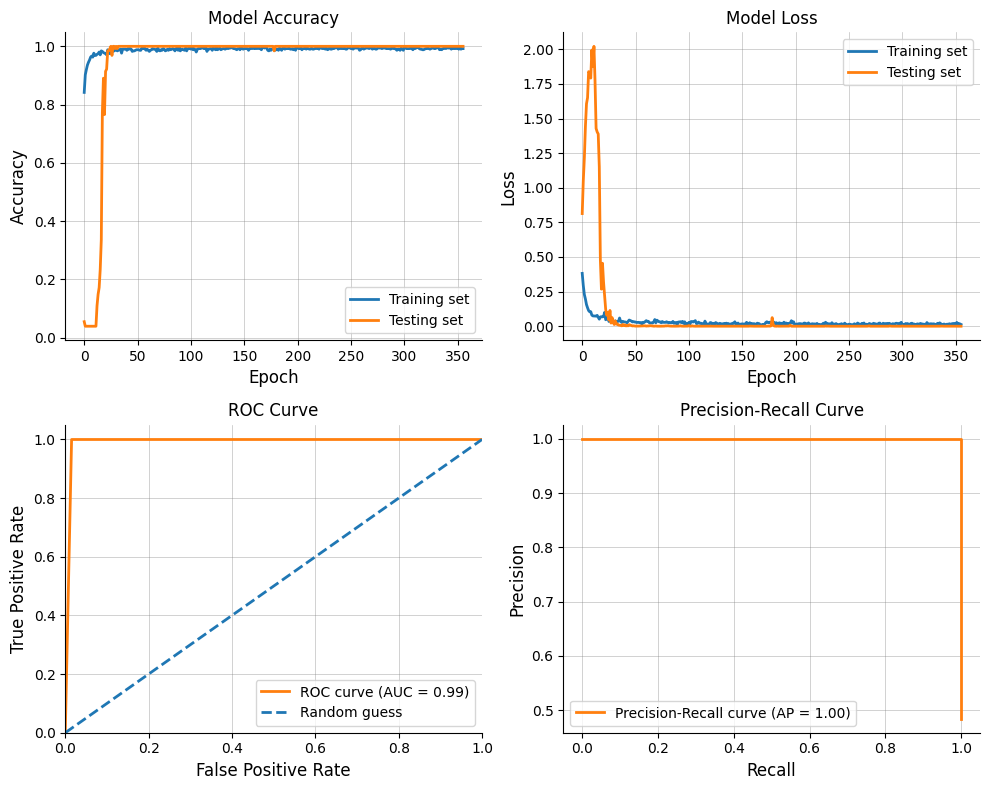

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Set background color and grid style for all subplots
fig.set_facecolor('white')
for ax in axes.flat:
    ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Plot accuracy
axes[0, 0].plot(history.history['accuracy'], linewidth=2, color='#1f77b4', label='Training set')
axes[0, 0].plot(history.history['val_accuracy'], linewidth=2, color='#ff7f0e', label='Testing set')
axes[0, 0].set_title('Model Accuracy', fontsize=12, fontweight='normal')
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].legend(loc='lower right', fontsize=10)
axes[0, 0].tick_params(axis='both', which='major', labelsize=10)

# Plot loss
axes[0, 1].plot(history.history['loss'], linewidth=2, color='#1f77b4', label='Training set')
axes[0, 1].plot(history.history['val_loss'], linewidth=2, color='#ff7f0e', label='Testing set')
axes[0, 1].set_title('Model Loss', fontsize=12, fontweight='normal')
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].legend(loc='upper right', fontsize=10)
axes[0, 1].tick_params(axis='both', which='major', labelsize=10)

# Compute the ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
axes[1, 0].plot(fpr, tpr, color='#ff7f0e', linewidth=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1, 0].plot([0, 1], [0, 1], color='#1f77b4', linewidth=2, linestyle='--', label='Random guess')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[1, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[1, 0].set_title('ROC Curve', fontsize=12, fontweight='normal')
axes[1, 0].tick_params(axis='both', which='major', labelsize=10)
axes[1, 0].legend(loc='lower right', fontsize=10)

# Compute Precision-Recall curve and average precision score
y_score = model.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

# Plot Precision-Recall curve
axes[1, 1].plot(recall, precision, color='#ff7f0e', linewidth=2, label=f'Precision-Recall curve (AP = {ap:.2f})')
axes[1, 1].set_xlabel('Recall', fontsize=12)
axes[1, 1].set_ylabel('Precision', fontsize=12)
axes[1, 1].set_title('Precision-Recall Curve', fontsize=12, fontweight='normal')
axes[1, 1].tick_params(axis='both', which='major', labelsize=10)
axes[1, 1].legend(loc="lower left", fontsize=10)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

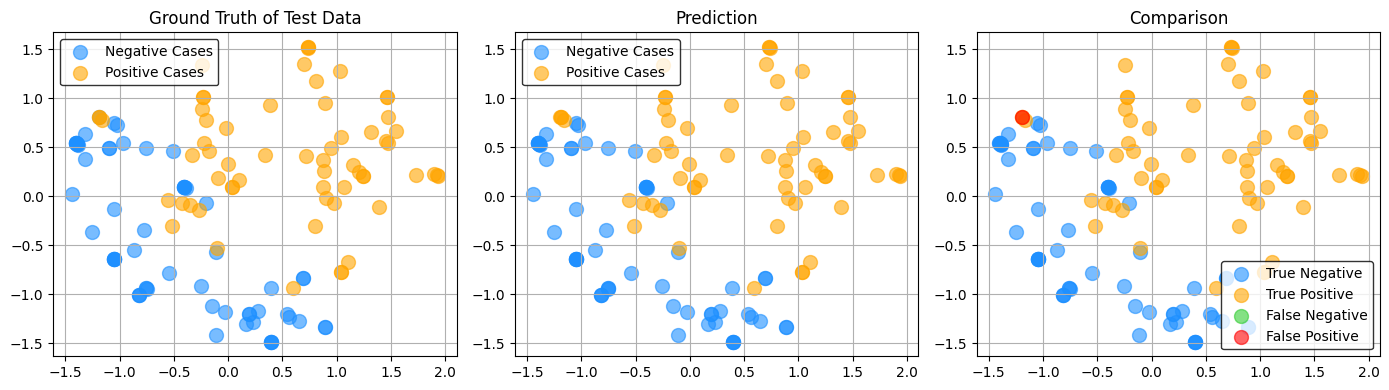

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def pca_plot(test_x_scaled, test_y, test_y_pred, size=100, markersize=1):
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(test_x_scaled)

    true_np = np.hstack((x_pca, test_y.reshape(len(test_y), 1)))
    pred_np = np.hstack((x_pca, test_y_pred.reshape(len(test_y_pred), 1)))

    column_true = ['pc_0', 'pc_1', 'true']
    column_pred = ['pc_0', 'pc_1', 'pred']

    true_df = pd.DataFrame(data=true_np, columns=column_true)
    pred_df = pd.DataFrame(data=pred_np, columns=column_pred)

    true_df_0 = true_df[true_df['true'] == 0]
    true_df_1 = true_df[true_df['true'] == 1]
    true_x_0 = true_df_0.iloc[:, :-1].to_numpy()
    true_x_1 = true_df_1.iloc[:, :-1].to_numpy()

    pred_df_0 = pred_df[pred_df['pred'] == 0]
    pred_df_1 = pred_df[pred_df['pred'] == 1]
    pred_x_0 = pred_df_0.iloc[:, :-1].to_numpy()
    pred_x_1 = pred_df_1.iloc[:, :-1].to_numpy()

    join_df = true_df.join(pred_df['pred'], rsuffix='_pred')

    correct_df = join_df[join_df['true'] == join_df['pred']]
    wrong_df = join_df[join_df['true'] != join_df['pred']]

    correct_df_0 = correct_df[correct_df['true'] == 0]
    correct_df_1 = correct_df[correct_df['true'] == 1]
    correct_x_0 = correct_df_0.iloc[:, :-2].to_numpy()
    correct_x_1 = correct_df_1.iloc[:, :-2].to_numpy()

    fn_df = wrong_df[wrong_df['pred'] == 0]
    fp_df = wrong_df[wrong_df['pred'] == 1]
    fn_x = fn_df.iloc[:, :-2].to_numpy()
    fp_x = fp_df.iloc[:, :-2].to_numpy()

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

    # Plot Ground Truth
    ax1.scatter(true_x_0[:, 0], true_x_0[:, 1], c='dodgerblue', s=size, alpha=0.6, label='Negative Cases')
    ax1.scatter(true_x_1[:, 0], true_x_1[:, 1], c='orange', s=size, alpha=0.6, label='Positive Cases')
    ax1.legend(markerscale=markersize, loc='best', frameon=True, facecolor='white', edgecolor='black')
    ax1.set_title('Ground Truth of Test Data', fontsize=12)
    # ax1.set_xlabel('Principal Component 1', fontsize=12)
    # ax1.set_ylabel('Principal Component 2', fontsize=12)
    ax1.grid(True)

    # Plot Predictions
    ax2.scatter(pred_x_0[:, 0], pred_x_0[:, 1], c='dodgerblue', s=size, alpha=0.6, label='Negative Cases')
    ax2.scatter(pred_x_1[:, 0], pred_x_1[:, 1], c='orange', s=size, alpha=0.6, label='Positive Cases')
    ax2.legend(markerscale=markersize, loc='best', frameon=True, facecolor='white', edgecolor='black')
    ax2.set_title('Prediction', fontsize=12)
    # ax2.set_xlabel('Principal Component 1', fontsize=12)
    # ax2.set_ylabel('Principal Component 2', fontsize=12)
    ax2.grid(True)

    # Plot Comparison
    ax3.scatter(correct_x_0[:, 0], correct_x_0[:, 1], c='dodgerblue', s=size, alpha=0.6, label='True Negative')
    ax3.scatter(correct_x_1[:, 0], correct_x_1[:, 1], c='orange', s=size, alpha=0.6, label='True Positive')
    ax3.scatter(fn_x[:, 0], fn_x[:, 1], c='limegreen', s=size, alpha=0.6, label='False Negative')
    ax3.scatter(fp_x[:, 0], fp_x[:, 1], c='red', s=size, alpha=0.6, label='False Positive')
    ax3.legend(markerscale=markersize, loc='best', frameon=True, facecolor='white', edgecolor='black')
    ax3.set_title('Comparison', fontsize=12)
    # ax3.set_xlabel('Principal Component 1', fontsize=12)
    # ax3.set_ylabel('Principal Component 2', fontsize=12)
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
pca_plot(X_test, y_test, y_pred, size=100, markersize=1)
